In [20]:
#Importing Libraries
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch import nn
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import EMNIST
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Loading Dataset
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor()
)

emnist_train = EMNIST(root='./data', split='balanced', train=True, download=True, transform=ToTensor())
emnist_test = EMNIST(root='./data', split='balanced', train=False, download=True, transform=ToTensor())

emnist_train_loader = DataLoader(emnist_train, batch_size=64, shuffle=True)
emnist_test_loader = DataLoader(emnist_test, batch_size=1000, shuffle=False)

print("MNIST classes:", len(train_data.classes))
print("EMNIST Balanced classes:", len(emnist_train.classes))

100%|██████████| 9.91M/9.91M [00:00<00:00, 19.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 482kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.42MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.0MB/s]
100%|██████████| 562M/562M [00:02<00:00, 234MB/s]


MNIST classes: 10
EMNIST Balanced classes: 47


In [3]:
#DataLoader for MNIST
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False)

In [4]:
# Determining the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [5]:
#Model Building
class CNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*7*7, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64*7*7)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# For MNIST
mnist_model = CNN(num_classes=10).to(device)

# For EMNIST
emnist_model = CNN(num_classes=47).to(device)

In [6]:
def train_model(model, train_loader, val_loader, epochs=10, lr=0.001):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    train_acc, val_acc = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        correct, total = 0, 0
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            _, pred = output.max(1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)
        train_acc.append(100*correct/total)

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                _, pred = output.max(1)
                correct += pred.eq(target).sum().item()
                total += target.size(0)
        val_acc.append(100*correct/total)

        print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_acc[-1]:.2f}% | Val Acc: {val_acc[-1]:.2f}%")

    return train_acc, val_acc


In [8]:
# Train MNIST model
print("Epochs for MNIST model:")
train_model(mnist_model, train_loader, test_loader, epochs=10)

# Train EMNIST model
print("Epochs for EMNIST model:")
train_model(emnist_model, emnist_train_loader, emnist_test_loader, epochs=10)

Epochs for MNIST model:
Epoch 1/10 - Train Acc: 99.05% | Val Acc: 99.08%
Epoch 2/10 - Train Acc: 99.21% | Val Acc: 99.32%
Epoch 3/10 - Train Acc: 99.20% | Val Acc: 99.27%
Epoch 4/10 - Train Acc: 99.31% | Val Acc: 99.31%
Epoch 5/10 - Train Acc: 99.31% | Val Acc: 99.35%
Epoch 6/10 - Train Acc: 99.32% | Val Acc: 99.32%
Epoch 7/10 - Train Acc: 99.37% | Val Acc: 99.17%
Epoch 8/10 - Train Acc: 99.37% | Val Acc: 99.42%
Epoch 9/10 - Train Acc: 99.47% | Val Acc: 99.19%
Epoch 10/10 - Train Acc: 99.44% | Val Acc: 99.36%
Epochs for EMNIST model:
Epoch 1/10 - Train Acc: 78.94% | Val Acc: 85.37%
Epoch 2/10 - Train Acc: 80.55% | Val Acc: 86.16%
Epoch 3/10 - Train Acc: 81.71% | Val Acc: 86.31%
Epoch 4/10 - Train Acc: 82.47% | Val Acc: 86.84%
Epoch 5/10 - Train Acc: 83.20% | Val Acc: 87.07%
Epoch 6/10 - Train Acc: 83.78% | Val Acc: 87.07%
Epoch 7/10 - Train Acc: 84.17% | Val Acc: 86.98%
Epoch 8/10 - Train Acc: 84.64% | Val Acc: 87.14%
Epoch 9/10 - Train Acc: 84.94% | Val Acc: 87.40%
Epoch 10/10 - Train

([78.93794326241135,
  80.552304964539,
  81.70744680851064,
  82.46631205673759,
  83.19680851063829,
  83.77659574468085,
  84.16843971631205,
  84.63918439716312,
  84.93882978723404,
  85.302304964539],
 [85.37234042553192,
  86.15957446808511,
  86.31382978723404,
  86.83510638297872,
  87.06914893617021,
  87.07446808510639,
  86.97872340425532,
  87.1436170212766,
  87.40425531914893,
  87.77127659574468])

In [9]:
#Extendable CRNN
class CRNN(nn.Module):
    def __init__(self, img_h=28, num_channels=1, num_classes=47, hidden_size=128):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(num_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
        )
        self.rnn = nn.LSTM(128*7, hidden_size, num_layers=2, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        conv_out = self.cnn(x)
        b, c, h, w = conv_out.size()
        conv_out = conv_out.permute(0, 3, 1, 2)
        conv_out = conv_out.view(b, w, c*h)
        rnn_out, _ = self.rnn(conv_out)
        out = self.fc(rnn_out)
        return out


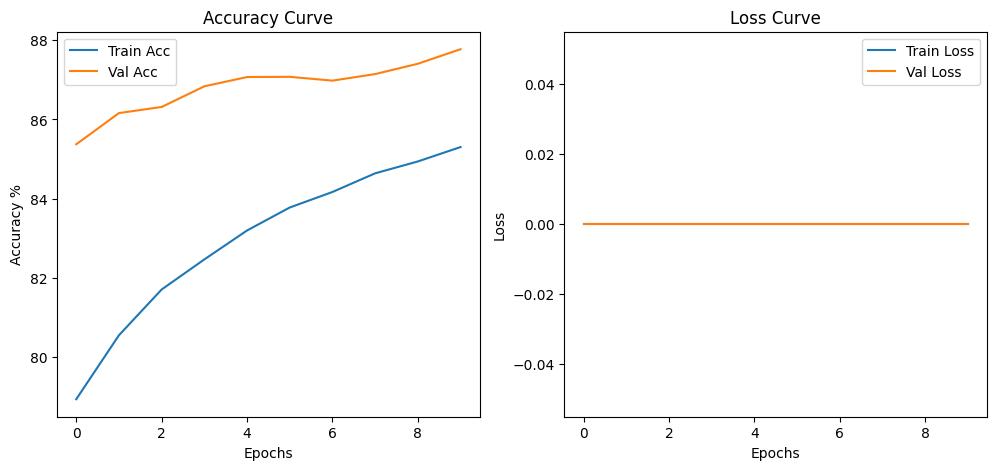

In [12]:
#Accuracy and Loss Curves
def plot_curves(train_acc, val_acc, train_loss, val_loss):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_acc, label="Train Acc")
    plt.plot(val_acc, label="Val Acc")
    plt.title("Accuracy Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy %")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Val Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

emnist_train_acc = [78.93794326241135, 80.552304964539, 81.70744680851064, 82.46631205673759, 83.19680851063829, 83.77659574468085, 84.16843971631205, 84.63918439716312, 84.93882978723404, 85.302304964539]
emnist_val_acc = [85.37234042553192, 86.15957446808511, 86.31382978723404, 86.83510638297872, 87.06914893617021, 87.07446808510639, 86.97872340425532, 87.1436170212766, 87.40425531914893, 87.77127659574468]


train_loss = [0] * len(emnist_train_acc)
val_loss = [0] * len(emnist_val_acc)


plot_curves(emnist_train_acc, emnist_val_acc, train_loss, val_loss)

Evaluation for MNIST model:


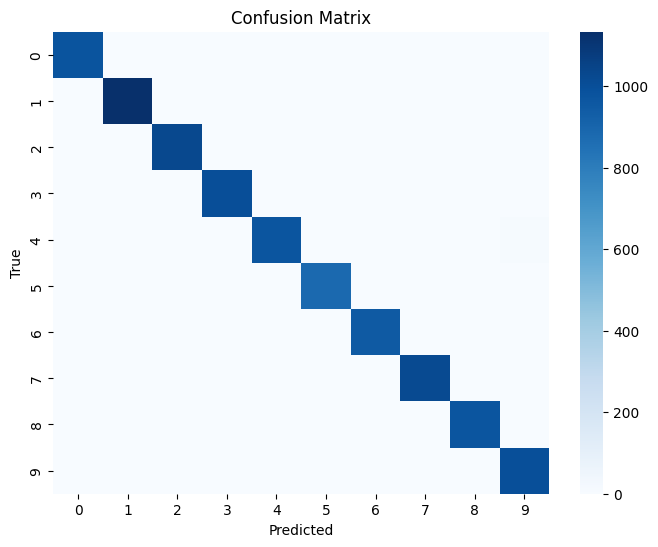

              precision    recall  f1-score   support

           0      0.994     0.998     0.996       980
           1      0.996     0.998     0.997      1135
           2      0.993     0.995     0.994      1032
           3      0.994     0.992     0.993      1010
           4      0.995     0.988     0.991       982
           5      0.989     0.992     0.990       892
           6      0.999     0.993     0.996       958
           7      0.993     0.993     0.993      1028
           8      0.996     0.996     0.996       974
           9      0.987     0.990     0.989      1009

    accuracy                          0.994     10000
   macro avg      0.994     0.994     0.994     10000
weighted avg      0.994     0.994     0.994     10000


Evaluation for EMNIST model:


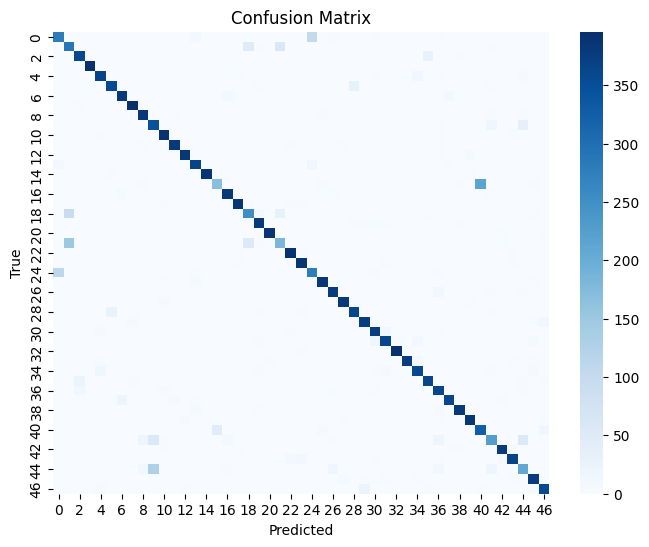

              precision    recall  f1-score   support

           0      0.691     0.698     0.694       400
           1      0.536     0.720     0.615       400
           2      0.896     0.900     0.898       400
           3      0.987     0.985     0.986       400
           4      0.915     0.920     0.918       400
           5      0.915     0.892     0.904       400
           6      0.929     0.950     0.939       400
           7      0.964     0.990     0.977       400
           8      0.904     0.963     0.932       400
           9      0.648     0.870     0.743       400
          10      0.942     0.975     0.958       400
          11      0.974     0.955     0.965       400
          12      0.965     0.960     0.962       400
          13      0.922     0.920     0.921       400
          14      0.980     0.970     0.975       400
          15      0.779     0.422     0.548       400
          16      0.929     0.948     0.938       400
          17      0.970    

In [16]:
#Confusion Matrix and Classification Report
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model(model, test_loader, num_classes):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            preds = output.argmax(dim=1)
            y_true.extend(target.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=False, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Report
    print(classification_report(y_true, y_pred, digits=3))
    # Evaluate MNIST model
print("Evaluation for MNIST model:")
evaluate_model(mnist_model, test_loader, num_classes=10)

# Evaluate EMNIST model
print("\nEvaluation for EMNIST model:")
evaluate_model(emnist_model, emnist_test_loader, num_classes=47)

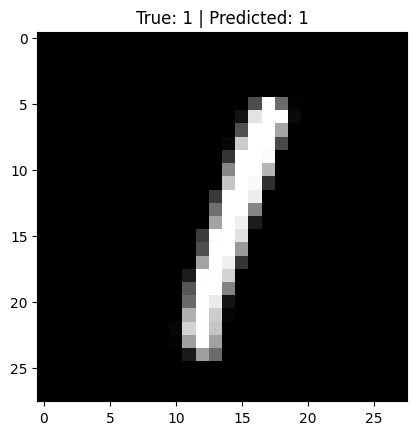

In [19]:
#Implementation
def predict_single(model, dataset, idx):
    image, label = dataset[idx]
    model.eval()
    with torch.no_grad():
        output = model(image.unsqueeze(0).to(device))
        pred = output.argmax(dim=1).item()

    plt.imshow(image.squeeze(), cmap="gray")
    plt.title(f"True: {label} | Predicted: {pred}")
    plt.show()

# Example: check 5th image
predict_single(mnist_model, test_data, 5)